In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pytorch_lightning &> /dev/null

import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib import patches
import copy
import torch
import torch.nn as nn
import pytorch_lightning as pl
from sklearn import metrics
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
import torch.nn.functional as F
from pytorch_lightning.loggers import tensorboard
import torchvision
import torchvision.transforms 
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import draw_bounding_boxes
from PIL import ImageColor
from dataset import Datasetbuilder
from dataset import visualize_raw_processor
from torch.optim.lr_scheduler import MultiStepLR
import warnings
warnings.filterwarnings("ignore")


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 21
torch.manual_seed(seed);

## Code Structure
In this assignment, we are only providing the barest templates for your code structure. If you prefer, you can write and debug most of the components in a regular python and only use Jupyter to train. In this case, you might have several files that you import into this notebook, e.g.
* `dataset.py`
* `model.py`
* `train.py`
* `inference.py`

This is shown below. All files should be included in your submission.

In [ ]:
try:
    import dataset
    import model
    import train
    import inference
except ModuleNotFoundError:
    pass

## Overview

Instance segmentation can be thought of as a combination of object detection and semantic segmentation, the former of which you already explored in the previous project. A visulization of this relationship can be seen in fig. 1.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig1.png" width=500/></div>
<center>Figure 1: An overview of instance segmentation.</center>  

In this project, you are tasked with implementing an instance segmentation framework know as SOLO (Segmenting Object by LOcations). In a similar manner to YOLO, SOLO produces mask predictions on a dense grid. This means that, unlike many other segmenation frameworks (e.g. Mask-RCNN), SOLO directly predicts the segmentation mask without proposing bounding box locations. An visual summary of SOLO can be seen in fig. 2 and 3.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig2.png" width=200/></div>
<center>Figure 2: SOLO.</center>  

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig3.png" width=600/></div>
<center>Figure 3: SOLO branches.</center>

These dense predictions are produced at several different scales using a Feature Pyramid Network (FPN). Using the last few layers of the backbone, we pass the higher level features from the deeper layers back up to larger features scales using lateral connections, shown in fig. 4. The integration of the FPN into your network will be the primary focus of this project.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig4.png" width=300/></div>
<center>Figure 4: SOLO branches.</center>

## Part A

### Dataset
#### Dataset Structure
The dataset used in this project contains three classes across 3265 images: vehicles, people, and animals. The dataset contains the following elements:

* A numpy array of images ($3 \times 300 \times 400$).
* A numpy array of masks ($300 \times 400$).
* A list of ground truth labels by image.
* A list of bounding boxes by image.

Note that the mask array is flattened; to determine which masks belong to which image, count the number of labels associated with that image. For example, if the first few images have 3, 2, and 4 labels, masks 0-2 would belong to image 1, masks 3-4 would belong to image 2, etc. The masks are ordered correctly to allow for this. You can find the dataset set here: https://drive.google.com/drive/folders/1eP7FtPaWfJ5zLdcsZYl6eyn5EYixkFn8

#### Loading and Batching
You should apply the following transformations to each image:
* Normalize pixel values to $[0,1]$.
* Rescale the image to $800 \times 1066$.
* Normalize each channel with means $[0.485, 0.456, 0.406]$ and standard deviations $[0.229, 0.224, 0.225]$.
* Zero pad the image to $800 \times 1088$.

Since each image will have a different number of objects, you will have to write your own collation function to properly batch the images. An example collate_fn is shown below, along with expected output dimensions.

In [3]:
path = {}
path["images"] = "/content/drive/MyDrive/CIS 6800/hw3_mycocodata_img_comp_zlib.h5" 
path["labels"] = "/content/drive/MyDrive/CIS 6800/hw3_mycocodata_labels_comp_zlib.npy"
path["bboxes"] = "/content/drive/MyDrive/CIS 6800/hw3_mycocodata_bboxes_comp_zlib.npy"
path["masks"] = "/content/drive/MyDrive/CIS 6800/hw3_mycocodata_mask_comp_zlib.h5"

In [4]:
solo = Datasetbuilder(path)

In [5]:
trainsize = 320
testsize = 80

torch.random.manual_seed(11)
# train_dataset, test_dataset = torch.utils.data.random_split(solo, [trainsize, testsize])

# Uncomment for serial data
train_dataset = torch.utils.data.Subset(solo, range(0,trainsize))
test_dataset = torch.utils.data.Subset(solo, range(trainsize, trainsize + testsize))
# test_dataset = torch.utils.data.Subset(solo, range(trainsize, 20+trainsize + 4))

In [6]:
# images:         (batch_size, 3, 800, 1088)
# labels:         list with len: batch_size, each (n_obj,)
# masks:          list with len: batch_size, each (n_obj, 800,1088)
# bounding_boxes: list with len: batch_size, each (n_obj, 4)
def custom_collate_fn(batch):

        images = []
        labels = []
        masks = []
        bboxes = []

        for i in batch:
            images.append(i[0])
            labels.append(i[1])
            masks.append(i[2])
            bboxes.append(i[3])

        return torch.stack(images, dim=0).to(device), labels, masks, bboxes

In [7]:
batch_size = 8
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)

#### Visualization
In order to validate that you are loading the dataset correct, you should plot at least five example images that include the mask, annotations, and bounding boxes. Examples of such images are shown in fig. 5 and 6. Make sure that the color for each class is consistent!

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig5.png" width=500/></div>
<center>Figure 5: Example visualization.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig6.png" width=500/></div>
<center>Figure 6: Example visualization.</center>

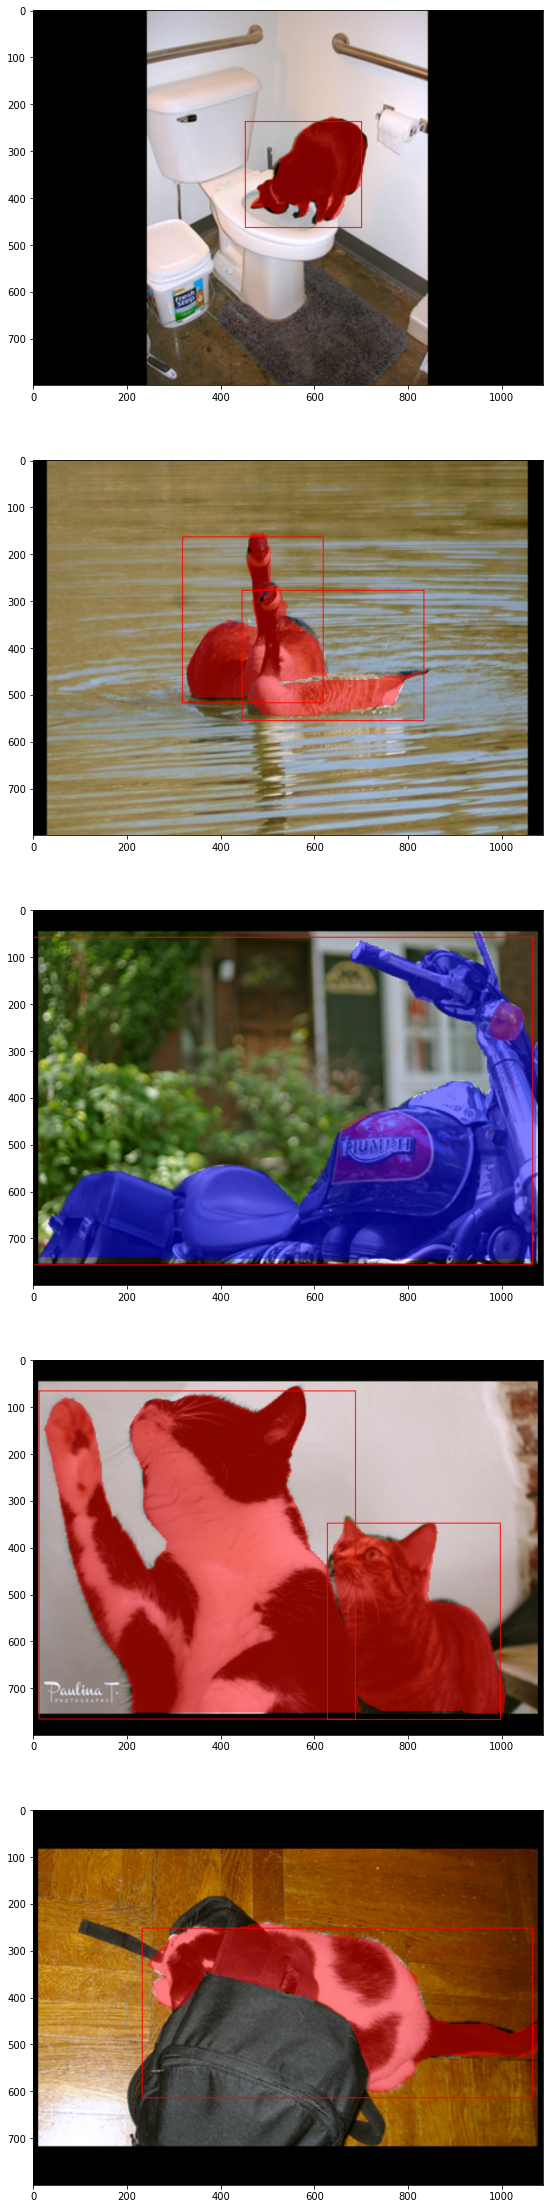

In [10]:
fig, ax = plt.subplots(5, figsize=(40, 40))
count = 0
temp_flag = True

for i, batch_set in enumerate(trainloader):
    img_set = batch_set[0]
    lab_set = batch_set[1]
    mask_set = batch_set[2]
    bbox_set = batch_set[3]
    for single_img, single_lab, single_mask, single_bbox in zip(img_set, lab_set, mask_set, bbox_set):
        final_img = visualize_raw_processor(single_img, single_lab, single_mask, single_bbox)
        ax[count].imshow(final_img)
        count += 1
        if count == 5:
            temp_flag = False
            break
    if temp_flag == False:
        break

### Model
#### Architecture
The model architecture is summarized in fig. 7 and tables 1 and 2.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig7.png" width=500/></div>
<center>Figure 7: SOLO branch structure.</center>
<br>
<center>Table 1: Category branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 3\times3\times(C-1)$, stride $= 1$, pad $= 1$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note $C = 4$ here (number of classes + background). |

<br>
<center>Table 2: Mask branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times(256 + 2)$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Two additional input channels represent the $x$ and $y$ positional encoding. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 1\times1\times(\text{num_grid})^2$, stride $= 1$, pad $= 0$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note that $\text{num_grid}$ is different for each layer of the FPN. |

We will be using a pretrained backbone (which includes an FPN), so you will not have to implement those components. A template for the network with along with default parameters is shown below.

#### Feature Pyramid
The feature pyramid extracted below has strides $[4,8,16,32,64]$ over the original image. To match the SOLO paper, this should be interpolated to have strides $[8,8,16,32,32]$.

#### Target Assignment
Some notes about generating the ground truth targets:
* The FPN levels can be though of as different grid sizes cut through the image.
* You assign each target to a certain FPN level if $\sqrt{wh}$ from the bounding box falls within the `scale_range` associated with that level. Note that these overlap, so you may assign the same target to multiple levels.
* A grid cell should be considered as predicting an object if that grid cell falls into the "centre region" of the object.
 * The centre region of an object is its bounding box scaled by `epsilon`.
 * Each grid cell can predict at most one object, but each object can be predicted by more than one grid cell.
 
#### Target Visualization
You should produce visualizations such as fig. 8 and 9 to validate your target assignments.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig8.png" width=500/></div>
<center>Figure 8: Target assignment example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig9.png" width=500/></div>
<center>Figure 9: Target assignment example.</center>

In [19]:
torch.cuda.empty_cache()


In [8]:
class SOLO(pl.LightningModule):
    _default_cfg = {
        'num_classes': 4,
        'in_channels': 256,
        'seg_feat_channels': 256,
        'stacked_convs': 7,
        'strides': [8, 8, 16, 32, 32],
        'scale_ranges': [(1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)],
        'epsilon': 0.2,
        'num_grids': [40, 36, 24, 16, 12],
        'mask_loss_cfg': dict(weight=3),
        'cate_loss_cfg': dict(gamma=2, alpha=0.25, weight=1),
        'postprocess_cfg': dict(cate_thresh=0.2, mask_thresh=0.5, pre_NMS_num=50, keep_instance=5, IoU_thresh=0.5)
    }
    
    def __init__(self, **kwargs):
        super().__init__()
        for k, v in {**self._default_cfg, **kwargs}.items():
            setattr(self, k, v)
        
        pretrained_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)
        self.backbone = pretrained_model.backbone

        self.train_loss_epoch = []
        self.train_cat_loss_epoch = []
        self.train_msk_loss_epoch = []

        self.val_loss_epoch = []
        self.val_cat_loss_epoch = []
        self.val_msk_loss_epoch = []


        """ Category Network """
        self.conv1 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['in_channels'], kernel_size=3, stride=1, padding=1, bias=False)
        self.gn1   = nn.GroupNorm(num_groups = 32, num_channels= 256)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['in_channels'], kernel_size=3, stride=1, padding=1, bias=False)
        self.gn2   = nn.GroupNorm(num_groups = 32, num_channels= 256)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['in_channels'], kernel_size=3, stride=1, padding=1, bias=False)
        self.gn3   = nn.GroupNorm(num_groups = 32, num_channels= 256)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['in_channels'], kernel_size=3, stride=1, padding=1, bias=False)
        self.gn4   = nn.GroupNorm(num_groups = 32, num_channels= 256)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['in_channels'], kernel_size=3, stride=1, padding=1, bias=False)
        self.gn5   = nn.GroupNorm(num_groups = 32, num_channels= 256)
        self.relu5 = nn.ReLU()

        self.conv6 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['in_channels'], kernel_size=3, stride=1, padding=1, bias=False)
        self.gn6   = nn.GroupNorm(num_groups = 32, num_channels= 256)
        self.relu6 = nn.ReLU()

        self.conv7 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['in_channels'], kernel_size=3, stride=1, padding=1, bias=False)
        self.gn7   = nn.GroupNorm(num_groups = 32, num_channels= 256)
        self.relu7 = nn.ReLU()

        self.conv_out0 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['num_classes']-1, kernel_size=3, stride=1, padding=1, bias=True)
        self.sig0 = nn.Sigmoid()

        """ Mask network """
        self.conv8 = nn.Conv2d(in_channels=self._default_cfg['in_channels']+2, out_channels=self._default_cfg['in_channels'], kernel_size=3, stride=1, padding=1, bias=False)
        self.gn8   = nn.GroupNorm(num_groups = 32, num_channels= 256)
        self.relu8 = nn.ReLU()

        self.conv9 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['in_channels'], kernel_size=3, stride=1, padding=1, bias=False)
        self.gn9   = nn.GroupNorm(num_groups = 32, num_channels= 256)
        self.relu9 = nn.ReLU()

        self.conv10 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['in_channels'], kernel_size=3, stride=1, padding=1, bias=False)
        self.gn10   = nn.GroupNorm(num_groups = 32, num_channels= 256)
        self.relu10 = nn.ReLU()

        self.conv11 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['in_channels'], kernel_size=3, stride=1, padding=1, bias=False)
        self.gn11   = nn.GroupNorm(num_groups = 32, num_channels= 256)
        self.relu11 = nn.ReLU()

        self.conv12 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['in_channels'], kernel_size=3, stride=1, padding=1, bias=False)
        self.gn12   = nn.GroupNorm(num_groups = 32, num_channels= 256)
        self.relu12 = nn.ReLU()

        self.conv13 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['in_channels'], kernel_size=3, stride=1, padding=1, bias=False)
        self.gn13   = nn.GroupNorm(num_groups = 32, num_channels= 256)
        self.relu13 = nn.ReLU()

        self.conv14 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['in_channels'], kernel_size=3, stride=1, padding=1, bias=False)
        self.gn14   = nn.GroupNorm(num_groups = 32, num_channels= 256)
        self.relu14 = nn.ReLU()

        self.conv_out1 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['num_grids'][0]**2, kernel_size=1, stride=1, padding=0, bias=True)
        self.sig1 = nn.Sigmoid()
        
        self.conv_out2 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['num_grids'][1]**2, kernel_size=1, stride=1, padding=0, bias=True)
        self.sig2 = nn.Sigmoid()
        
        self.conv_out3 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['num_grids'][2]**2, kernel_size=1, stride=1, padding=0, bias=True)
        self.sig3 = nn.Sigmoid()
        
        self.conv_out4 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['num_grids'][3]**2, kernel_size=1, stride=1, padding=0, bias=True)
        self.sig4 = nn.Sigmoid()
        
        self.conv_out5 = nn.Conv2d(in_channels=self._default_cfg['in_channels'], out_channels=self._default_cfg['num_grids'][4]**2, kernel_size=1, stride=1, padding=0, bias=True)
        self.sig5 = nn.Sigmoid()



    def category_forward(self, x):
        x = self.relu1(self.gn1(self.conv1(x)))
        x = self.relu2(self.gn2(self.conv2(x)))
        x = self.relu3(self.gn3(self.conv3(x)))
        x = self.relu4(self.gn4(self.conv4(x)))
        x = self.relu5(self.gn5(self.conv5(x)))
        x = self.relu6(self.gn6(self.conv6(x)))
        x = self.relu7(self.gn7(self.conv7(x)))
        x = self.sig0(self.conv_out0(x))
        return x

    def mask_forward(self, x, i):
        x = self.relu8(self.gn8(self.conv8(x).unsqueeze(0)))
        x = self.relu9(self.gn9(self.conv9(x)))
        x = self.relu10(self.gn10(self.conv10(x)))
        x = self.relu11(self.gn11(self.conv11(x)))
        x = self.relu12(self.gn12(self.conv12(x)))
        x = self.relu13(self.gn13(self.conv13(x)))
        x = self.relu14(self.gn14(self.conv14(x)))
        if i == 0 :
          x = self.sig1(self.conv_out1(x))
        elif i == 1 :
          x = self.sig2(self.conv_out2(x))
        elif i == 2 :
          x = self.sig3(self.conv_out3(x))
        elif i == 3 : 
          x = self.sig4(self.conv_out4(x))
        elif i == 4:
          x = self.sig5(self.conv_out5(x))
        return x
    
   
    # Forward function should calculate across each level of the feature pyramid network.
    # Input:
    #     images: batch_size number of images
    # Output:
    #     if eval = False
    #         category_predictions: list, len(fpn_levels), each (batch_size, C-1, S, S)
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, 2*feature_h, 2*feature_w)
    #     if eval==True
    #         category_predictions: list, len(fpn_levels), each (batch_size, S, S, C-1)
    #         / after point_NMS
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, image_h/4, image_w/4)
    #         / after upsampling
    def forward(self, images, eval):
        # you can modify this if you want to train the backbone
        feature_pyramid = [v.detach() for v in self.backbone(images).values()] # this has strides [4,8,16,32,64]

        cat_final_pred = []
        msk_final_pred = []

        for i in range(len(feature_pyramid)):
                    
          H_f = int(800 / self._default_cfg["strides"][i])
          W_f = int(1088/ self._default_cfg["strides"][i])

          image_h = int(800 / 4)
          image_w = int(1088 / 4)
          
          if eval == True :
            stacked_cats = torch.zeros((batch_size, self._default_cfg["num_grids"][i], self._default_cfg["num_grids"][i], self._default_cfg["num_classes"]-1))
            stacked_msks = torch.zeros((batch_size, self._default_cfg["num_grids"][i]**2, image_h, image_w))       
          else : 
            stacked_cats = torch.zeros((batch_size, self._default_cfg["num_classes"]-1, self._default_cfg["num_grids"][i], self._default_cfg["num_grids"][i]))
            stacked_msks = torch.zeros((batch_size, self._default_cfg["num_grids"][i]**2, 2*H_f, 2*W_f))

          for num in range(0, len(images)):
            net_ip = feature_pyramid[i][num].to(device)

            if i == 0 or (len(feature_pyramid) - 1):
              net_ip = F.interpolate(feature_pyramid[i][num].unsqueeze(0), size=(2*H_f, 2*W_f), mode='bilinear')

            category_net_ip = F.interpolate(net_ip, size=(self._default_cfg['num_grids'][i] , self._default_cfg['num_grids'][i] ) , mode = 'bilinear').to(device)

            category_net_op = self.category_forward(category_net_ip)

            mask_net_ip = net_ip.clone().to(device)
            x_channel, y_channel = torch.meshgrid(torch.arange(mask_net_ip.shape[2], device=device), torch.arange(mask_net_ip.shape[3], device=device))
            x_channel = x_channel.to(device)
            y_channel = y_channel.to(device)
            
            # Normalize between -1 and 1
            x_channel_norm = x_channel - torch.min(x_channel)
            x_channel_norm = x_channel_norm/torch.max(x_channel_norm)
            x_channel_norm = (x_channel_norm - 0.5)/0.5 

            y_channel_norm = y_channel - torch.min(y_channel)
            y_channel_norm = y_channel_norm/torch.max(y_channel_norm)
            y_channel_norm = (y_channel_norm - 0.5)/0.5 

            mask_net_ip = torch.cat([mask_net_ip.squeeze(0), x_channel_norm.unsqueeze(0), y_channel_norm.unsqueeze(0)], dim=0)

            mask_net_op = self.mask_forward(mask_net_ip, i)

            if eval == True : 
              cat_net_op_eval = category_net_op.permute(0,2,3,1)
              stacked_cats[num] = cat_net_op_eval
              mask_net_op_eval = F.interpolate(mask_net_op, size=(image_h, image_w), mode='bilinear')
              stacked_msks[num] = mask_net_op_eval
            else : 
              stacked_msks[num] = mask_net_op
              stacked_cats[num] = category_net_op

          cat_final_pred.append(stacked_cats)
          msk_final_pred.append(stacked_msks)

        return cat_final_pred, msk_final_pred


    def focal_loss(self, cat_tar, cat_pred):

      cat_tar_flattened = torch.cat([torch.cat([each_level.flatten() for each_level in each_image]) for each_image in cat_tar]).type(torch.long)   # Shape : batch_size x (1600 + 1296 + 576 + 256 + 144) (3872)
      one_hot_cat_tar = F.one_hot(cat_tar_flattened, num_classes=4)[:,1:]
      one_hot_cat_tar_flattened = one_hot_cat_tar.clone().flatten().to(device)                                                                   # Shape : len x 3 flattened

      cat_pred_flattened = torch.cat([each_channel.permute(0,2,3,1).reshape(-1,3) for each_channel in cat_pred])                                   # Shape : batch_size x (1600 + 1296 + 576 + 256 + 144) flattened
      new_cat = cat_pred_flattened.clone().flatten().to(device)

      idx = torch.where(one_hot_cat_tar_flattened!=0)[0]

      alphas = torch.ones_like(one_hot_cat_tar_flattened) * self._default_cfg["cate_loss_cfg"]["alpha"]

      alphas[idx] = 1 - self._default_cfg["cate_loss_cfg"]["alpha"]
      gamma = self._default_cfg["cate_loss_cfg"]["gamma"]

      ones = torch.ones(idx.shape[0])
      new_cat[idx] = 1 - new_cat[idx]
      focal_loss = torch.sum(-alphas * torch.pow(1 - new_cat, gamma) * torch.log(new_cat + 0.0000001)) / (3*cat_tar_flattened.shape[0])

      return focal_loss

    def dice_loss(self, m1, m2): 
      m1 = m1.to(device)
      m2 = m2.to(device)
      dice_sum = torch.sum(2*m1 * m2) / (torch.sum(torch.pow(m1, 2)) + torch.sum(torch.pow(m2, 2) + 0.000001))
      return 1 - dice_sum

    # Input : Shape ()
    # msk_pred : len(fpn), batch x S^2 x 2H x 2W
    # msk_tar : len(batch), len(fpn), S^2 x 2H x 2W
    # act_msk : len(batch), len(fpn), (S^2,)
    def mask_loss(self, msk_tar, msk_pred, act_msk):
      N_pos = 0
      tot_loss = 0
      loss_each_image = []
      for i in range(len(msk_tar)):                  # one image
        loss_every_level = []
        one_loss = 0
        for each_level in range(5):
          flattened_act_level = act_msk[i][each_level]               # Shape : (S^2,)
          N_pos += torch.sum(flattened_act_level)
          idx = torch.where(flattened_act_level!=0)[0]
          if len(idx) == 0:
            continue
          active_msk_tar_level = msk_tar[i][each_level][idx]      
          active_msk_pred_level = msk_pred[each_level][i][idx]
          for k in range(active_msk_pred_level.shape[0]):
            one_loss += self.dice_loss(active_msk_tar_level[k], active_msk_pred_level[k])
          loss_every_level.append(one_loss)
        loss_each_image.append(sum(loss_every_level)/5)
      tot_loss = sum(loss_each_image)/len(loss_each_image)
      return tot_loss/N_pos

    # Loss function
    # Input: 
    #     category_predictions: list, len(fpn_levels), each (batch_size, C-1, S, S)
    #     mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, 2*feature_h, 2*feature_w)
    def loss_tot(self, cat_pred, msk_pred, cat_tar, msk_tar, act_msk):
        lambda_cat = self._default_cfg["cate_loss_cfg"]['weight']
        lambda_msk = self._default_cfg["mask_loss_cfg"]['weight']
        
        cat_loss = lambda_cat * self.focal_loss(cat_tar,cat_pred)
        msk_loss = lambda_msk * self.mask_loss(msk_tar, msk_pred, act_msk)
        final_loss = cat_loss + msk_loss

        # print("c loss : ", cat_loss)
        # print("m loss : ", msk_loss)
        
        return final_loss, msk_loss, cat_loss

        
    # This function build the ground truth tensor for each batch in the training
    # Input:
    #     bounding_boxes:   list, len(batch_size), each (n_object, 4) (x1 y1 x2 y2 system)
    #     labels:           list, len(batch_size), each (n_object, )
    #     masks:            list, len(batch_size), each (n_object, 800, 1088)
    # Output:
    #     category_targets: list, len(batch_size), list, len(fpn), (S, S), values are {1, 2, 3}
    #     mask_targets:     list, len(batch_size), list, len(fpn), (S^2, 2*feature_h, 2*feature_w)
    #     active_masks:     list, len(batch_size), list, len(fpn), (S^2,)
    #     / boolean array with positive mask predictions
    def generate_targets(self, bounding_boxes, labels, masks):
      category_targets = []
      mask_targets = []
      active_masks = []

      for sin_box, sin_lab, sin_mask in zip(bounding_boxes, labels, masks):

        x_centre_scaled_mat = torch.zeros(5, sin_lab.shape[0])       # Initializing
        y_centre_scaled_mat = torch.zeros(5, sin_lab.shape[0])
        w_scaled = torch.zeros(5, sin_lab.shape[0])
        h_scaled = torch.zeros(5, sin_lab.shape[0])
        w_h = torch.zeros((sin_box.shape[0],2))

        w_h[:,0] = sin_box[:,2] - sin_box[:,0]          # for x (w)
        w_h[:,1] = sin_box[:,3] - sin_box[:,1]          # for y (h)
        area = torch.sqrt(w_h[:,0] * w_h[:,1])          # area
        x_centre = (sin_box[:,2] + sin_box[:,0]) / 2    # x centre
        y_centre = (sin_box[:,3] + sin_box[:,1]) / 2    # y centre

        # Scaled x centre for each level
        x_centre_scaled_mat[0] = x_centre * (self._default_cfg["num_grids"][0] / 1088)
        x_centre_scaled_mat[1] = x_centre * (self._default_cfg["num_grids"][1] / 1088)
        x_centre_scaled_mat[2] = x_centre * (self._default_cfg["num_grids"][2] / 1088)
        x_centre_scaled_mat[3] = x_centre * (self._default_cfg["num_grids"][3] / 1088)
        x_centre_scaled_mat[4] = x_centre * (self._default_cfg["num_grids"][4] / 1088) 
        # Scaled y centre for each level
        y_centre_scaled_mat[0] = y_centre * (self._default_cfg["num_grids"][0] / 800)
        y_centre_scaled_mat[1] = y_centre * (self._default_cfg["num_grids"][1] / 800)
        y_centre_scaled_mat[2] = y_centre * (self._default_cfg["num_grids"][2] / 800)
        y_centre_scaled_mat[3] = y_centre * (self._default_cfg["num_grids"][3] / 800)
        y_centre_scaled_mat[4] = y_centre * (self._default_cfg["num_grids"][4] / 800) 
        # Scaled w
        w_scaled[0] = w_h[:,0] * (self._default_cfg["num_grids"][0] / 1088)
        w_scaled[1] = w_h[:,0] * (self._default_cfg["num_grids"][1] / 1088)
        w_scaled[2] = w_h[:,0] * (self._default_cfg["num_grids"][2] / 1088)
        w_scaled[3] = w_h[:,0] * (self._default_cfg["num_grids"][3] / 1088)
        w_scaled[4] = w_h[:,0] * (self._default_cfg["num_grids"][4] / 1088)
        # Scaled h
        h_scaled[0] = w_h[:,1] * (self._default_cfg["num_grids"][0] / 800)
        h_scaled[1] = w_h[:,1] * (self._default_cfg["num_grids"][1] / 800)
        h_scaled[2] = w_h[:,1] * (self._default_cfg["num_grids"][2] / 800)
        h_scaled[3] = w_h[:,1] * (self._default_cfg["num_grids"][3] / 800)
        h_scaled[4] = w_h[:,1] * (self._default_cfg["num_grids"][4] / 800)
        
        level_list = [torch.logical_and(self._default_cfg["scale_ranges"][0][0] < area, area < self._default_cfg["scale_ranges"][0][1]).int(), 
                      torch.logical_and(self._default_cfg["scale_ranges"][1][0] < area, area < self._default_cfg["scale_ranges"][1][1]).int(),
                      torch.logical_and(self._default_cfg["scale_ranges"][2][0] < area, area < self._default_cfg["scale_ranges"][2][1]).int(),
                      torch.logical_and(self._default_cfg["scale_ranges"][3][0] < area, area < self._default_cfg["scale_ranges"][3][1]).int(),
                      torch.logical_and(self._default_cfg["scale_ranges"][4][0] < area, area < self._default_cfg["scale_ranges"][4][1]).int()]

        fpn_each_image_cat = []
        fpn_each_image_mask = []
        fpn_each_image_active = []

        fpn_list_cat = [torch.zeros(self._default_cfg["num_grids"][0], self._default_cfg["num_grids"][0]).to(device),
                        torch.zeros(self._default_cfg["num_grids"][1], self._default_cfg["num_grids"][1]).to(device),
                        torch.zeros(self._default_cfg["num_grids"][2], self._default_cfg["num_grids"][2]).to(device),
                        torch.zeros(self._default_cfg["num_grids"][3], self._default_cfg["num_grids"][3]).to(device),
                        torch.zeros(self._default_cfg["num_grids"][4], self._default_cfg["num_grids"][4]).to(device)]

        fpn_list_mask = [torch.zeros(self._default_cfg["num_grids"][0]**2, int(2 * 800 / self._default_cfg["strides"][0]), int(2 * 1088 / self._default_cfg["strides"][0])).to(device),
                         torch.zeros(self._default_cfg["num_grids"][1]**2, int(2 * 800 / self._default_cfg["strides"][1]), int(2 * 1088 / self._default_cfg["strides"][1])).to(device),
                         torch.zeros(self._default_cfg["num_grids"][2]**2, int(2 * 800 / self._default_cfg["strides"][2]), int(2 * 1088 / self._default_cfg["strides"][2])).to(device),
                         torch.zeros(self._default_cfg["num_grids"][3]**2, int(2 * 800 / self._default_cfg["strides"][3]), int(2 * 1088 / self._default_cfg["strides"][3])).to(device),
                         torch.zeros(self._default_cfg["num_grids"][4]**2, int(2 * 800 / self._default_cfg["strides"][4]), int(2 * 1088 / self._default_cfg["strides"][4])).to(device)]  
        
        fpn_list_active = [torch.zeros(self._default_cfg["num_grids"][0]**2).to(device),
                           torch.zeros(self._default_cfg["num_grids"][1]**2).to(device),
                           torch.zeros(self._default_cfg["num_grids"][2]**2).to(device),
                           torch.zeros(self._default_cfg["num_grids"][3]**2).to(device),
                           torch.zeros(self._default_cfg["num_grids"][4]**2).to(device)]
        

        for level_id, each_level in enumerate(level_list):        # for each image
          each_level = each_level.view(sin_lab.shape[0], 1)

          H_f = int(800 / self._default_cfg["strides"][level_id])
          W_f = int(1088/ self._default_cfg["strides"][level_id])
     
          scaled_mask = F.interpolate(sin_mask.unsqueeze(0), size=(2*H_f, 2*W_f), mode='nearest').squeeze(0).to(device)     # Upscale to the 2*H_feature, 2*W_feature
 
          for label_id, each_label in enumerate(each_level):          # each_label = 0,0 for first level
            if each_label.item() == 0:
              continue
            else:
              # Scale down the boxes  
              x_top_left     = torch.round(x_centre_scaled_mat[level_id, label_id] - (self._default_cfg["epsilon"] * w_scaled[level_id, label_id] / 2))#.int().item()
              y_top_left     = torch.round(y_centre_scaled_mat[level_id, label_id] - (self._default_cfg["epsilon"] * h_scaled[level_id, label_id] / 2))#.int().item()
              x_bottom_right = torch.round(x_centre_scaled_mat[level_id, label_id] + (self._default_cfg["epsilon"] * w_scaled[level_id, label_id] / 2))#.int().item()
              y_bottom_right = torch.round(y_centre_scaled_mat[level_id, label_id] + (self._default_cfg["epsilon"] * h_scaled[level_id, label_id] / 2))#.int().item()
              # Bound the boxes to 3x3 grid
              x_top_bounded    = (max(x_top_left, x_centre_scaled_mat[level_id, label_id] - 1)).int().item()
              y_top_bounded    = (max(y_top_left, y_centre_scaled_mat[level_id, label_id] - 1)).int().item()
              x_bottom_bounded = (min(x_bottom_right, x_centre_scaled_mat[level_id, label_id] + 1)).int().item()
              y_bottom_bounded = (min(y_bottom_right, y_centre_scaled_mat[level_id, label_id] + 1)).int().item()
              # Create meshgrid for populating the mask label values
              xx, yy = torch.meshgrid(torch.arange(y_top_bounded, y_bottom_bounded+1, device=device), torch.arange(x_top_bounded, x_bottom_bounded+1, device=device))
              xx = xx.to(device)
              yy = yy.to(device)
              fpn_list_cat[level_id][xx, yy] = sin_lab[label_id].item()
              # Populating the mask target and active masks for corresponding level and label
              fpn_list_mask[level_id][xx.flatten()*self._default_cfg["num_grids"][level_id] + yy.flatten()] = scaled_mask[label_id]
              fpn_list_active[level_id][xx.flatten()*self._default_cfg["num_grids"][level_id] + yy.flatten()] = 1.

          # Appending one level
          fpn_each_image_mask.append(fpn_list_mask[level_id])
          fpn_each_image_cat.append(fpn_list_cat[level_id])
          fpn_each_image_active.append(fpn_list_active[level_id])
        # Appending one fpn set for each image in the batch
        category_targets.append(fpn_each_image_cat)
        mask_targets.append(fpn_each_image_mask)
        active_masks.append(fpn_each_image_active)

      return category_targets, mask_targets, active_masks


    def training_step(self, batch, batch_idx):
      images, labels, masks, bounding_boxes = batch
      cat_pred, msk_pred = self.forward(images, eval=False)
      category_targets, mask_targets, active_masks = self.generate_targets(bounding_boxes, labels, masks)
      train_loss, msk_loss, cat_loss = self.loss_tot(cat_pred, msk_pred, category_targets, mask_targets, active_masks)
  
      del images, labels, masks, bounding_boxes
      del mask_targets, category_targets, active_masks
      torch.cuda.empty_cache()

      self.log("train_loss", train_loss, prog_bar=True, on_epoch=True)
      self.log("mask_loss", msk_loss, prog_bar=True)
      self.log("category loss", cat_loss, prog_bar=True)

      return {"loss":train_loss, "msk_loss":msk_loss, "cat_loss":cat_loss}

    def training_epoch_end(self, training_step_outputs):
      avg_train_loss = 0
      avg_cat_loss = 0
      avg_mask_loss = 0
      for i in range(len(training_step_outputs)):
        avg_train_loss += training_step_outputs[i]["loss"].detach().cpu().item()
        avg_cat_loss += training_step_outputs[i]["cat_loss"].detach().cpu().item()
        avg_mask_loss += training_step_outputs[i]["msk_loss"].detach().cpu().item()
      
      self.train_loss_epoch.append(avg_train_loss)
      self.train_cat_loss_epoch.append(avg_cat_loss)
      self.train_msk_loss_epoch.append(avg_mask_loss)


    def validation_step(self, batch, batch_idx):
      images, labels, masks, bounding_boxes = batch
      cat_pred, msk_pred = self.forward(images, eval=False)
      category_targets, mask_targets, active_masks = self.generate_targets(bounding_boxes, labels, masks)
      val_loss, msk_loss, cat_loss = self.loss_tot(cat_pred, msk_pred, category_targets, mask_targets, active_masks)

      del images, labels, masks, bounding_boxes
      del mask_targets, category_targets, active_masks
      torch.cuda.empty_cache()

      self.log("val_loss", val_loss)
      return {"loss":val_loss, "msk_loss":msk_loss, "cat_loss":cat_loss}

    def validation_epoch_end(self, outputs):
      avg_train_loss = 0
      avg_cat_loss = 0
      avg_mask_loss = 0
      for i in range(len(outputs)):
        avg_train_loss += outputs[i]["loss"].detach().cpu().item()
        avg_cat_loss += outputs[i]["cat_loss"].detach().cpu().item()
        avg_mask_loss += outputs[i]["msk_loss"].detach().cpu().item()
      
      self.val_loss_epoch.append(avg_train_loss)
      self.val_cat_loss_epoch.append(avg_cat_loss)
      self.val_msk_loss_epoch.append(avg_mask_loss)


    def configure_optimizers(self):
      optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
      scheduler = MultiStepLR(optimizer, milestones=[27,33], gamma=0.1)

      return optimizer

    def points_nms(self, heat, kernel=2):
      # kernel must be 2
      hmax = F.max_pool2d(
          heat, (kernel, kernel), stride=1, padding=1)
      keep = (hmax[:, :, :-1, :-1] == heat).float()
      return heat * keep

    # Input :
    #   Category prediction : Shape len(fpn) (S, S, C-1)
    #   Mask prediction : Shape len(fpn) (S^2, image_h/4, image_w/4)
    # Output :

    def post_process(self, cat, msk):

      flattened_cats = torch.cat([torch.flatten(cat_each_level, start_dim=0, end_dim=1) for cat_each_level in cat])   # Shape (5*S^2, C-1)
      flattened_msks = torch.cat(msk)    # Shape (5*S^2, image_h/4, image_w/4)

      c_max, c_max_ind = torch.max(flattened_cats, dim=1)

      idx = torch.where(c_max > self._default_cfg["postprocess_cfg"]["cate_thresh"])[0]
      above_thresh_cmax = c_max[idx]
      above_thresh_cmax_ind = c_max_ind[idx]

      above_thres_msks = flattened_msks[idx]

      scores = torch.stack([torch.mean(above_thres_one_msk[torch.where(above_thres_one_msk > self._default_cfg["postprocess_cfg"]["mask_thresh"])]*above_thresh_cmax_each) 
                                    for above_thres_one_msk, above_thresh_cmax_each in zip(above_thres_msks.float(), above_thresh_cmax.float())])
      scores = torch.nan_to_num(scores, nan=0.)

      sorted_scores, sorted_indices = torch.sort(scores, descending=True)
      sorted_msks = above_thres_msks[sorted_indices]
      sorted_classes = above_thresh_cmax_ind[sorted_indices]

      nms_scores = MatrixNMS(sorted_msks, sorted_scores)
      sorted_nms_scores, sorted_nms_ind = torch.sort(nms_scores, descending=True)
      sorted_masks_final = sorted_msks[sorted_nms_ind]

      sorted_nms_classes = sorted_classes[sorted_nms_ind]

      first_five_msks = sorted_masks_final[:2]
      final_classes = sorted_nms_classes[:2]

      final_msks = F.interpolate(first_five_msks.unsqueeze(0), size=(800, 1088), mode="bilinear")

      return final_msks, final_classes

# Credit to SOLO Author's code
# This function does NMS on the heat map (category_prediction), grid-level
# Input:
#     heat: (batch_size, C-1, S, S)
# Output:
#     (batch_size, C-1, S, S)
def points_nms(heat, kernel=2):
    # kernel must be 2
    hmax = F.max_pool2d(
        heat, (kernel, kernel), stride=1, padding=1)
    keep = (hmax[:, :, :-1, :-1] == heat).float()
    return heat * keep

# This function performs Matrix NMS
# Input:
#     sorted_masks: (n_active, image_h/4, image_w/4)
#     sorted_scores: (n_active,)
# Output:
#     decay_scores: (n_active,)
def MatrixNMS(sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
    n = len(sorted_scores)
    sorted_masks = sorted_masks.reshape(n, -1)
    intersection = torch.mm(sorted_masks, sorted_masks.T)
    areas = sorted_masks.sum(dim=1).expand(n, n)
    union = areas + areas.T - intersection
    ious = (intersection / union).triu(diagonal=1)

    ious_cmax = ious.max(0)[0].expand(n, n).T
    if method == 'gauss':
        decay = torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)
    else:
        decay = (1 - ious) / (1 - ious_cmax)
    decay = decay.min(dim=0)[0]
    return sorted_scores * decay


def visualize_nms_image(img_orig, ff_msks, classes,thresh=0.2, transp=0.2):
  manipulated_mask = torch.where(ff_msks>thresh, 1, 0)
  edit_im = img_orig.detach().cpu().numpy().copy()

  for x in range(len(manipulated_mask[0])):
    negative = np.where(manipulated_mask[0][x]==1, 0, 1)
    positive = np.where(manipulated_mask[0][x]==1, 255., 0)
    edit_im = img_orig.detach().cpu().numpy().copy()
    c = classes[x]
    edit_im[c] = edit_im[c]*negative + positive*(1-transp) + edit_im[c]*transp
    im = edit_im.squeeze().transpose(1,2,0)
    im = np.clip(im, 0, 1)
  plt.figure(figsize = (20,20))
  plt.imshow(im)




In [9]:
model = SOLO()

epochs = 45

logger = pl_loggers.TensorBoardLogger("tb_logs", name="SOLO")
# trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=epochs, logger=logger)
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=epochs, logger=logger)
trainer.fit(model, trainloader, testloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type            | Params
-----------------------------------------------
0  | backbone  | BackboneWithFPN | 26.8 M
1  | conv1     | Conv2d          | 589 K 
2  | gn1       | GroupNorm       | 512   
3  | relu1     | ReLU            | 0     
4  | conv2     | Conv2d          | 589 K 
5  | gn2       | GroupNorm       | 512   
6  | relu2     | ReLU            | 0     
7  | conv3     | Conv2d          | 589 K 
8  | gn3       | GroupNorm       | 512   
9  | relu3     | ReLU            | 0     
10 | conv4     | Conv2d          | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=45` reached.


In [ ]:
# PATH = 'model_full_working.pth'
# torch.save(model.state_dict(), PATH)

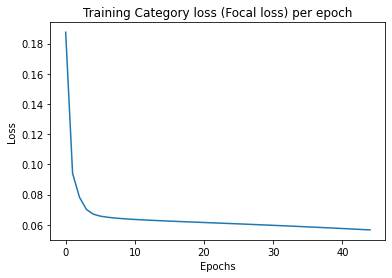

In [10]:
tot_cat_train_losses = model.train_cat_loss_epoch
plt.plot(tot_cat_train_losses)
plt.title("Training Category loss (Focal loss) per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

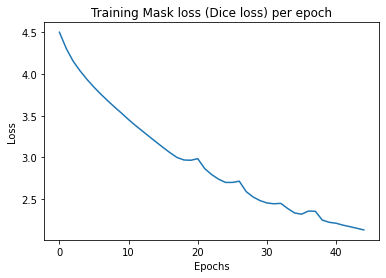

In [11]:
tot_msk_train_losses = model.train_msk_loss_epoch
plt.plot(tot_msk_train_losses)
plt.title("Training Mask loss (Dice loss) per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

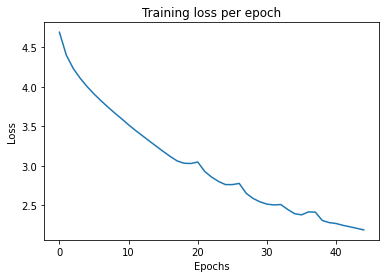

In [12]:
tot_train_losses = model.train_loss_epoch
plt.plot(tot_train_losses)
plt.title("Training loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

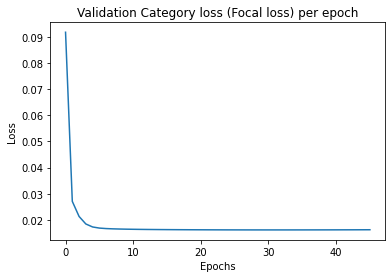

In [16]:
tot_cat_val_losses = model.val_cat_loss_epoch
plt.plot(tot_cat_val_losses)
plt.title("Validation Category loss (Focal loss) per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

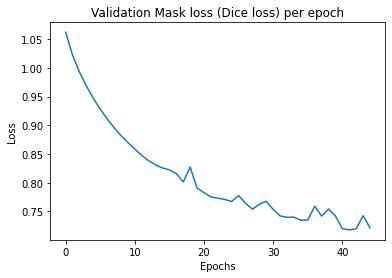

In [18]:
tot_msk_val_losses = model.val_msk_loss_epoch
plt.plot(tot_msk_val_losses)
plt.title("Validation Mask loss (Dice loss) per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

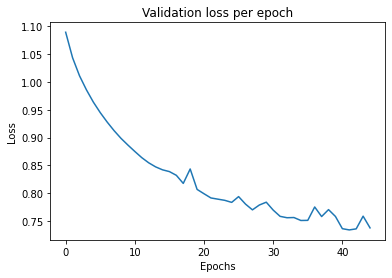

In [19]:
tot_val_losses = model.val_loss_epoch
plt.plot(tot_val_losses)
plt.title("Validation loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [15]:
def visualize_targets(msk_tar, act_msk,cat_tar, img):
        color_list = ['blue','green','red']
        for j in range(len(msk_tar)):
          for i in range(len(msk_tar[j])):
            fig         = plt.figure()
            ax          = fig.add_subplot()
            no_mask = img[j,:,:,:].cpu().numpy()
            no_mask = np.clip(no_mask, 0, 1)
            no_mask = no_mask.transpose(1,2,0)
            ax.imshow(no_mask)
            if sum(act_msk[j][i]) == 0 :

              plt.show()
              continue
            index = act_msk[j][i] > 0
            label = torch.flatten(cat_tar[j][i])[index]
            mask = msk_tar[j][i][index,:,:]
            mask = torch.unsqueeze(mask,1)

            reshaped_mask = F.interpolate(mask,(img.shape[2],img.shape[3]),mode='bilinear')
            
            combined_mask = np.zeros((img.shape[2],img.shape[3],img.shape[1]))

            for idx, l in enumerate(label):
              if l == 3:
                combined_mask[:,:,0] += (reshaped_mask[idx,0,:,:] ).cpu().numpy()
              if l == 2:
                combined_mask[:,:,1] += (reshaped_mask[idx,0,:,:] ).cpu().numpy()
              if l == 1:
                combined_mask[:,:,2] += (reshaped_mask[idx,0,:,:] ).cpu().numpy()
            
            origin_img = img[j,:,:,:].cpu().numpy()
            origin_img = np.clip(origin_img, 0, 1)
            origin_img = origin_img.transpose(1,2,0)
            index_to_mask = np.where(combined_mask > 0)
            masked_image = copy.deepcopy(origin_img)
            masked_image[index_to_mask[0],index_to_mask[1],:] = 0

            mask_to_plot = (combined_mask + masked_image)
            mask_to_plot = np.clip(mask_to_plot, 0, 1)
            ax.imshow(mask_to_plot)
            plt.show()
        if j == 6:
          return

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

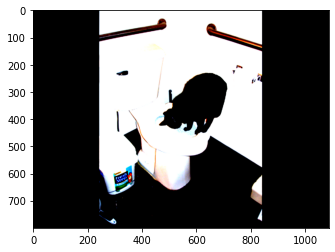

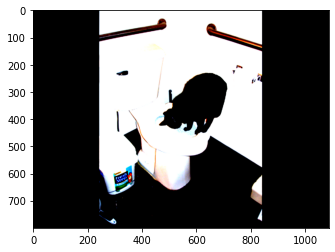

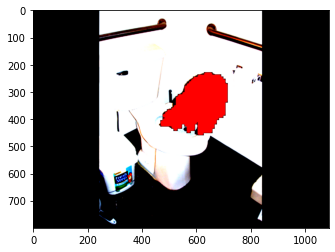

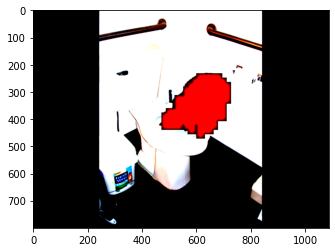

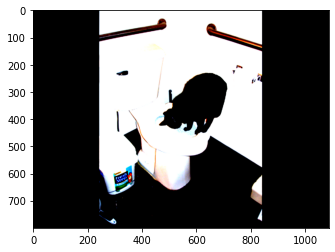

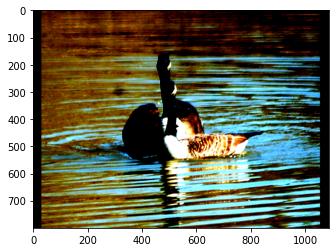

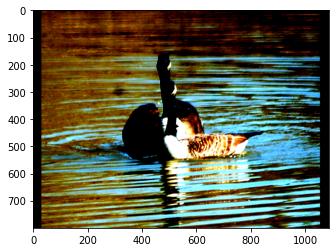

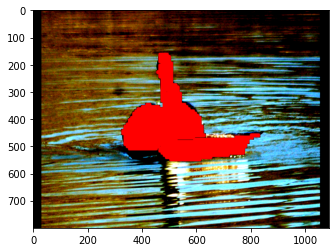

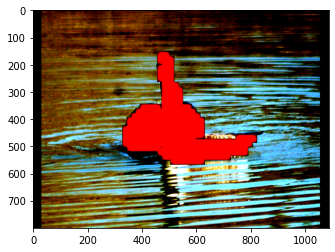

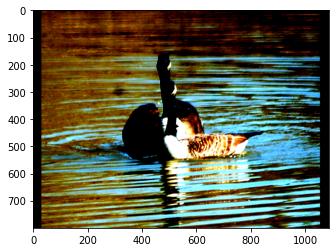

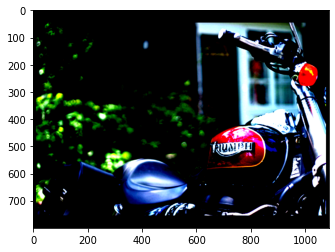

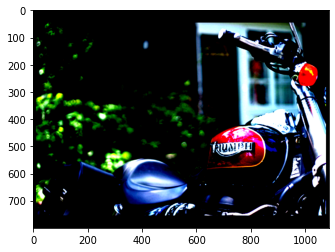

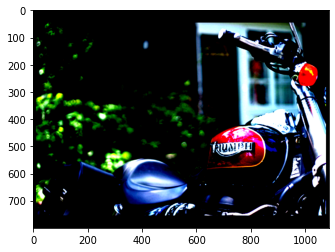

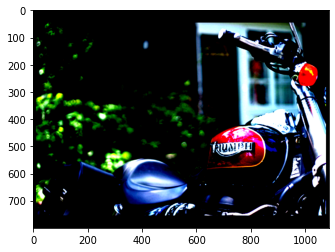

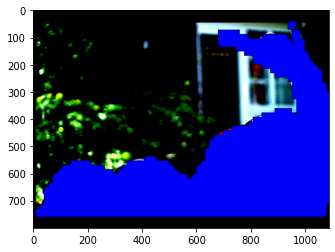

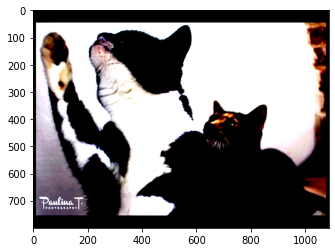

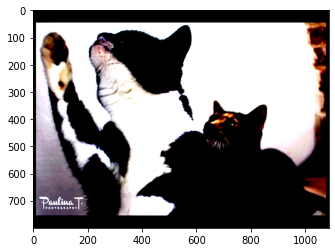

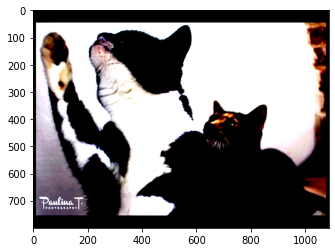

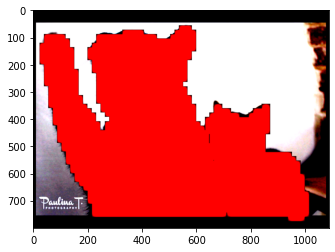

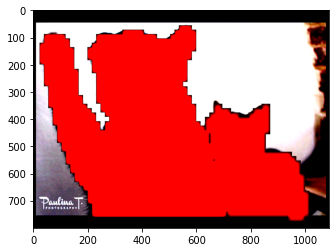

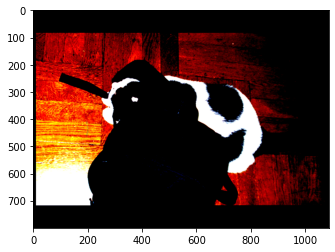

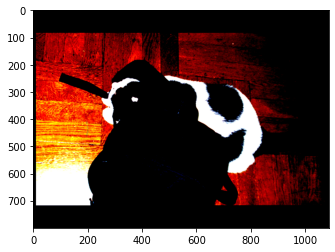

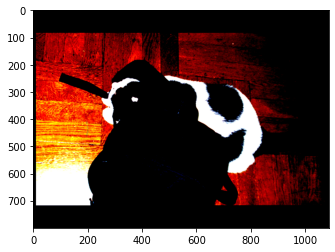

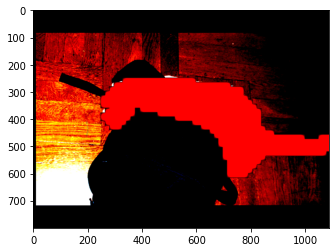

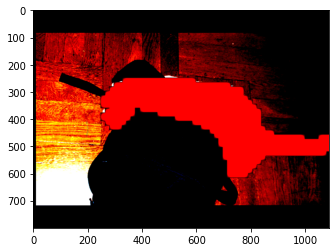

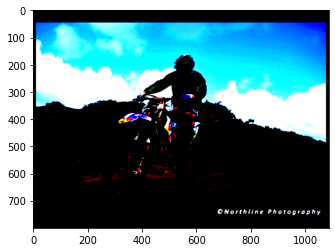

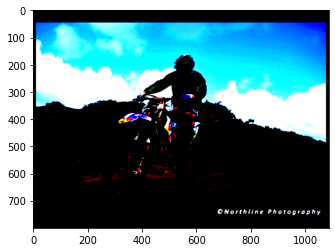

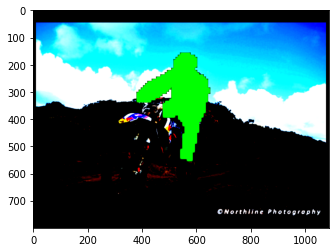

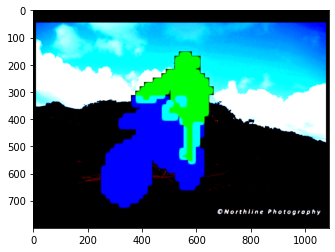

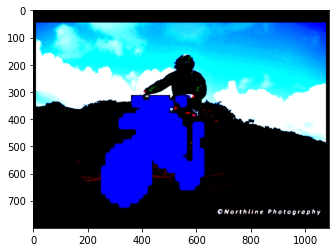

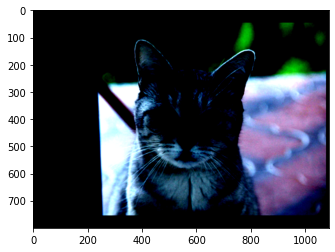

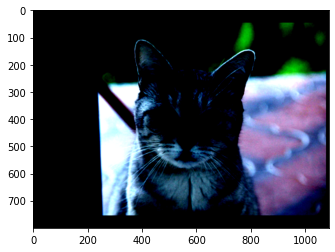

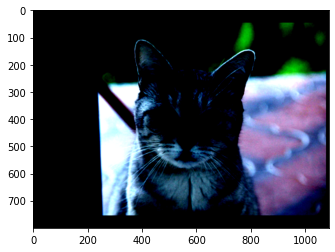

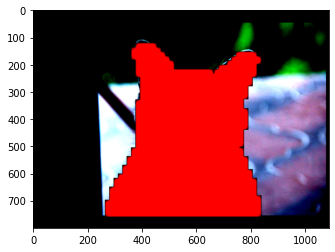

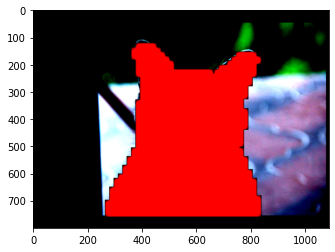

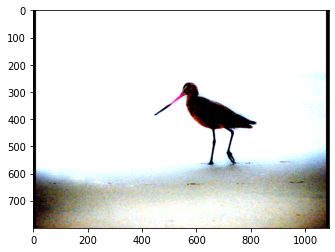

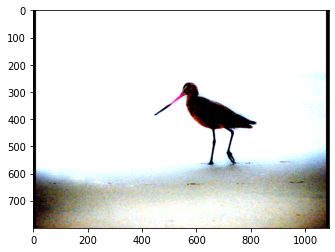

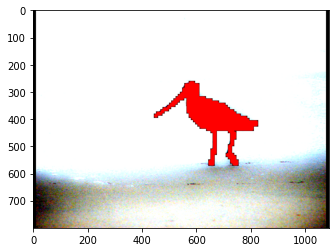

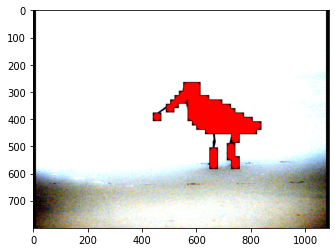

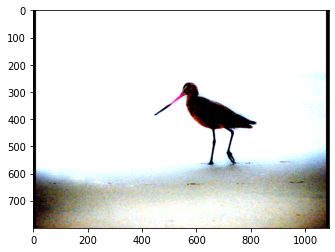

In [17]:
# For plotting 5 generated target images
# model = SOLO()
count = 0
temp_flag = True
for i, batch_set in enumerate(trainloader):
  img_set = batch_set[0]
  lab_set = batch_set[1]
  mask_set = batch_set[2]
  bbox_set = batch_set[3]
  cat_tar, msk_tar, act_msk = model.generate_targets(bbox_set, lab_set, mask_set)
  visualize_targets(msk_tar, act_msk, cat_tar, img_set)
  if i == 1:
    break



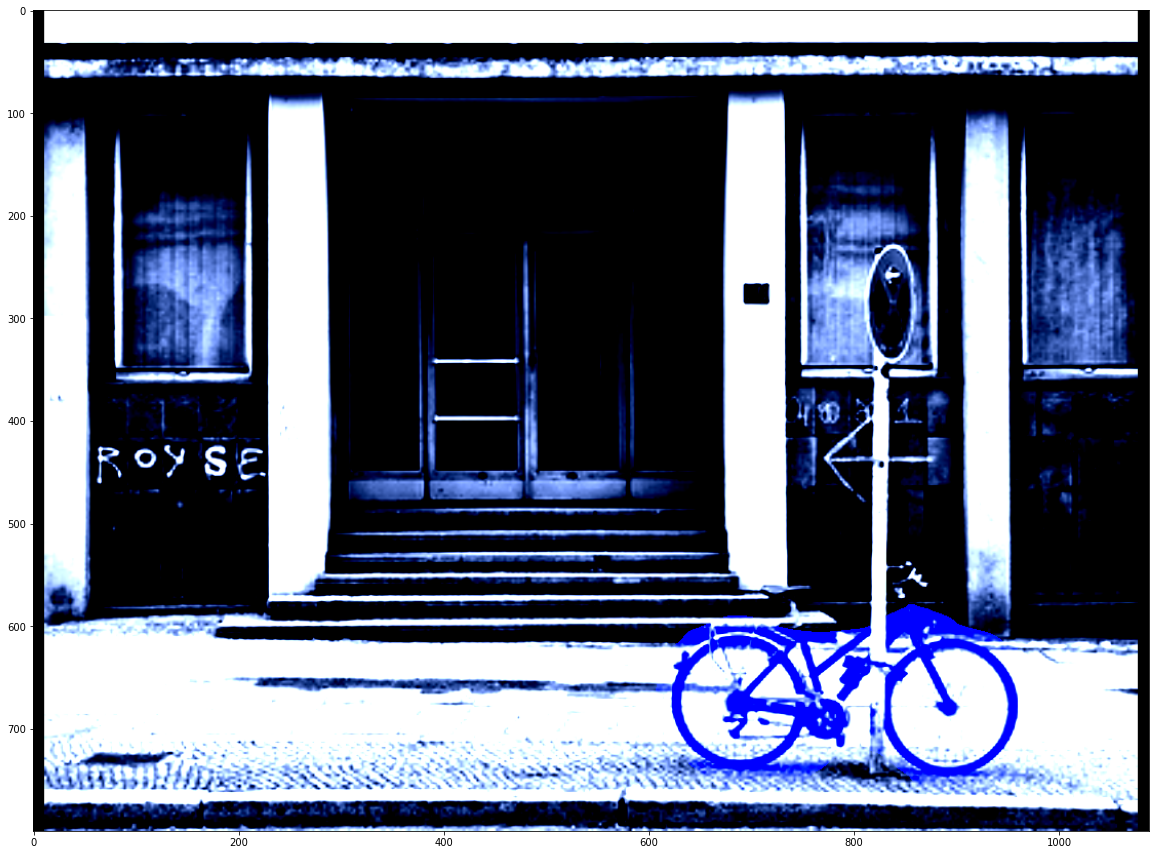

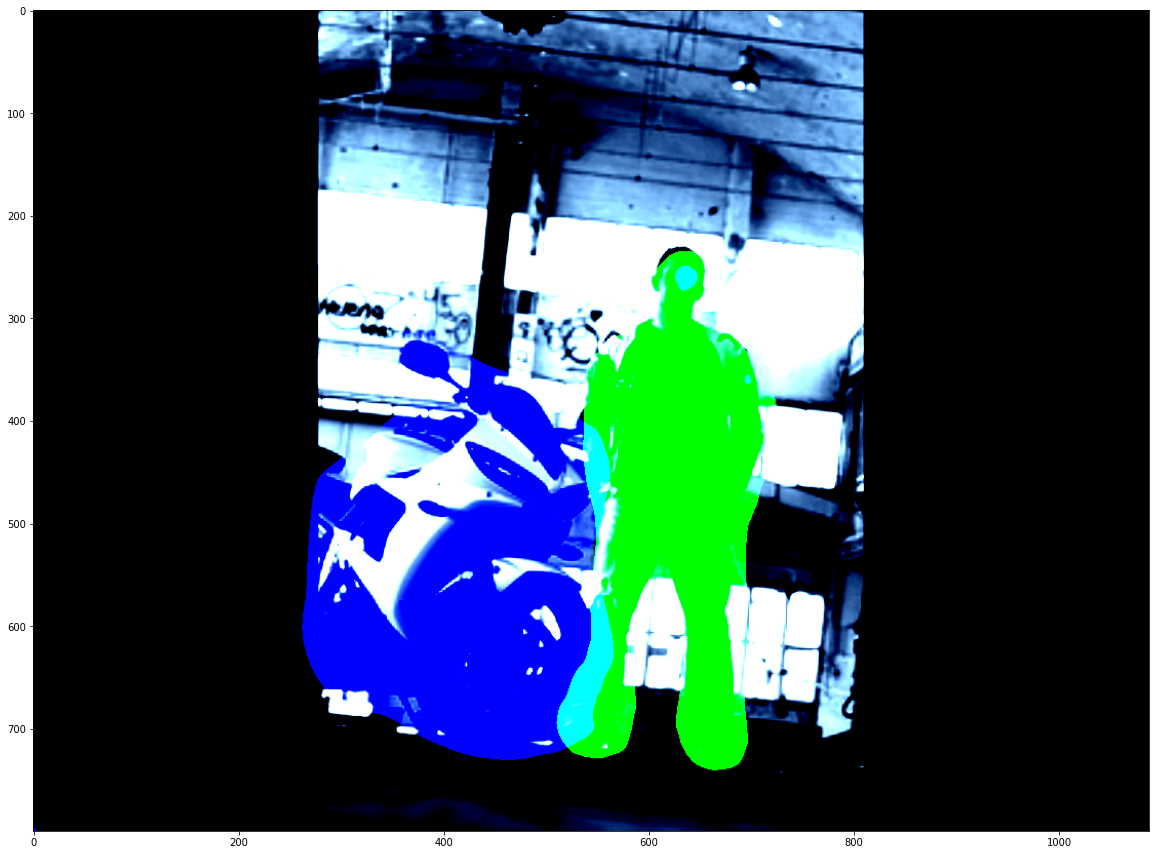

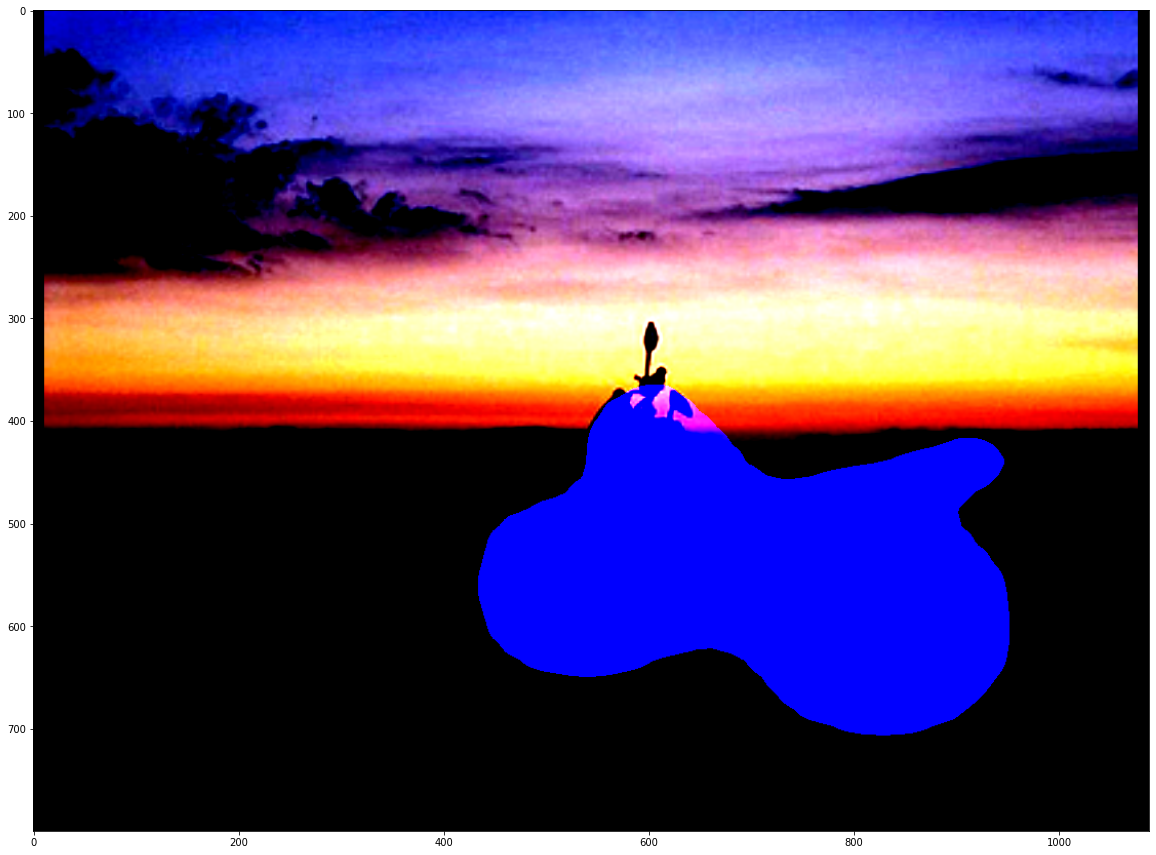

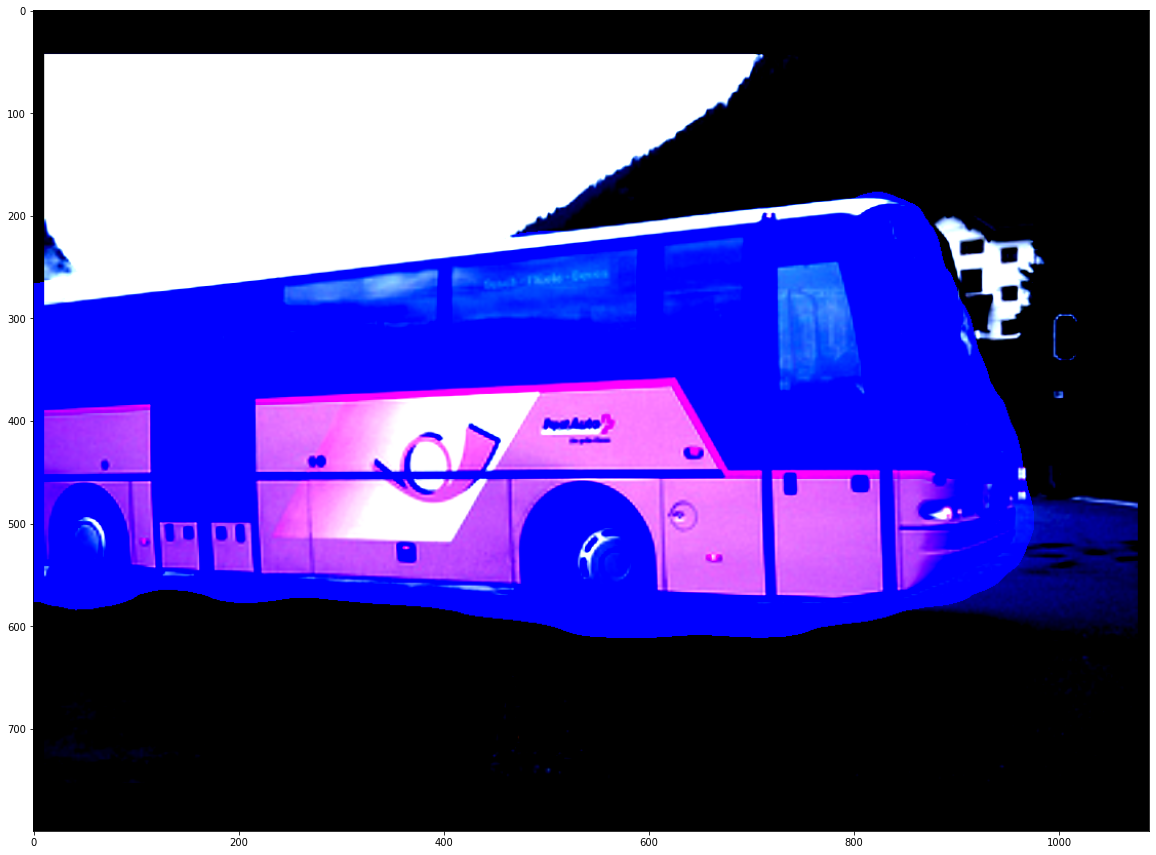

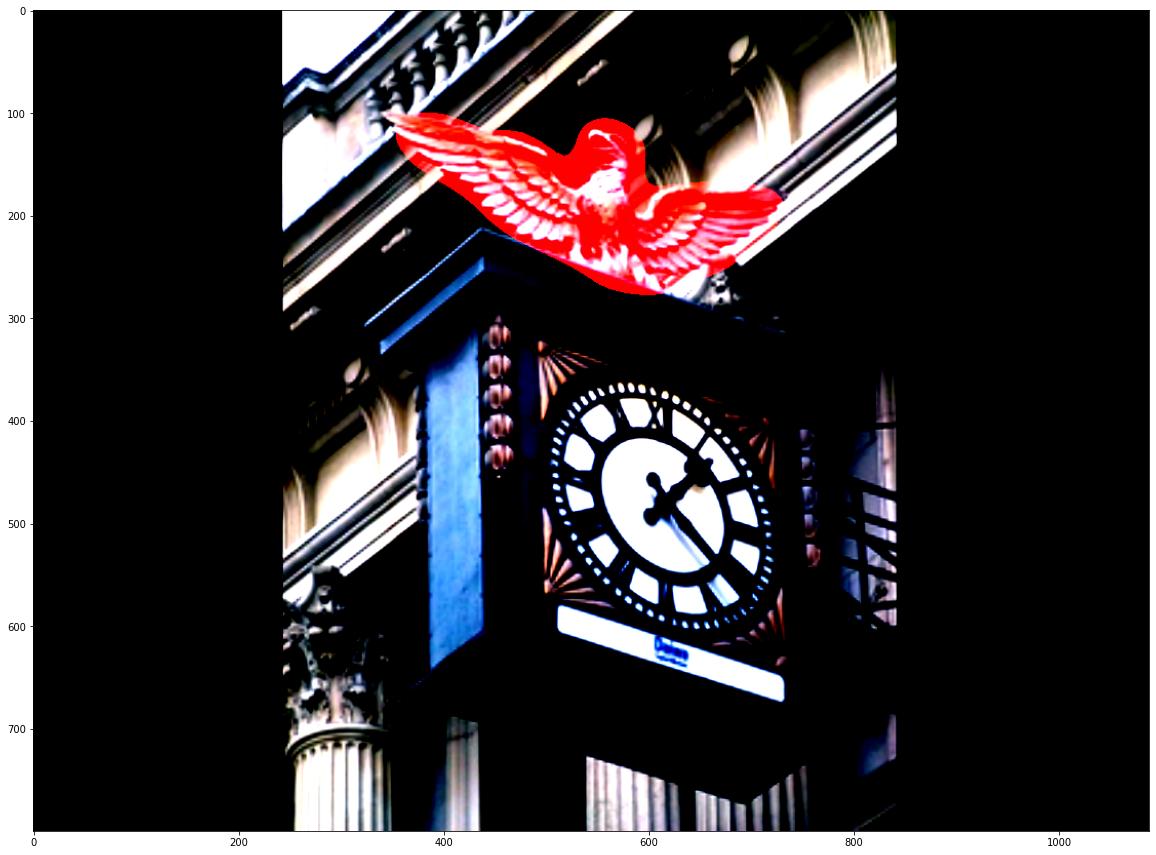

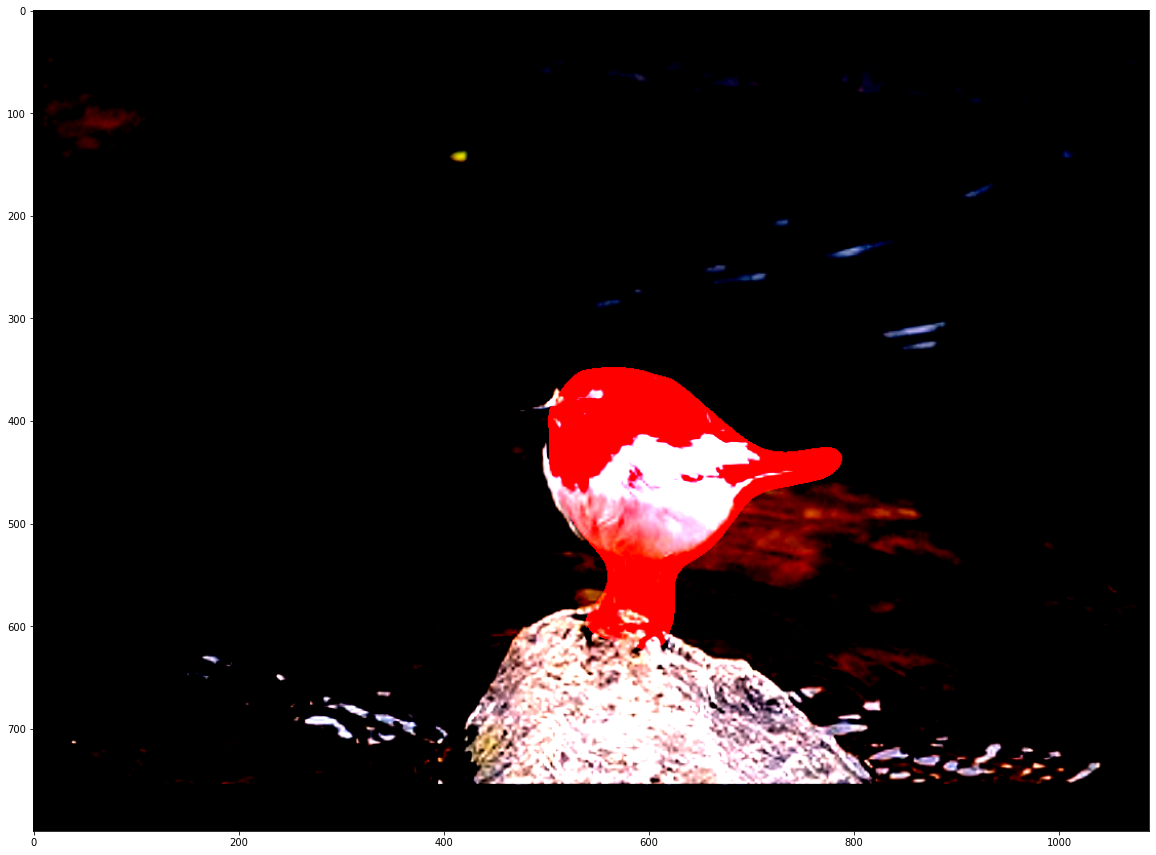

In [14]:
# Visualizing the results
model.eval()
model.to(device)
count = 0
temp_flag = True
for i, batch_set in enumerate(testloader):

  img_set  = batch_set[0]
  lab_set  = batch_set[1]
  mask_set = batch_set[2]
  bbox_set = batch_set[3]
  cat_tar, msk_tar, act_msk = model.generate_targets(bbox_set, lab_set, mask_set)

  cat_pred, msk_pred = model.forward(img_set, eval=True)

  for i in range(batch_size):
    img_raw = img_set[i].squeeze(0)
    nms_ip = [points_nms(cat_pred[j][i].unsqueeze(0).permute(0,3,1,2)).permute(0,2,3,1) for j in range(5)]
    cat_ip = [each_cat_level.squeeze(0) for each_cat_level in nms_ip]
    msk_ip = [msk_pred[j][i] for j in range(5)]
    fin_msk, fin_cls = model.post_process(cat_ip, msk_ip)
    visualize_nms_image(img_raw, fin_msk, fin_cls,thresh=0.2, transp=0.2)
    count += 1
    if count == 6:
      temp_flag = False
      break
      
  if temp_flag == False:
    break  


     

# To run  
We load the dataset into the algorithm my calling the dataset.py script which has the dataset builder class. Then, in colab we pass the dataset to trainloader and testloader to make it iterable. We have also written a custom collate function to append everything into a single list.
The results of part A can be visualized by calling the visualize_raw_processor from dataset.py which returns a final numpy image which can be plotted. 
For visualizing generate target, we call the function visualize_targets to which we pass the output of generate_targets function. 10 images for each visualization are plotted above.

## Part B
### Loss
The loss function consists of two parts: category loss and mask loss:
$$L = \lambda_\text{cate} L_\text{cate} + \lambda_\text{mask} L_\text{mask} $$

The category loss is defined as (where $\text{FL}$ is the focal loss)

$$L_\text{cate} = \frac{1}{S^2 C} \sum_{S,S,C} \text{FL}(p_t)$$

$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log{(p_t)}$$

$$(\alpha_t, p_t) = \left\{\begin{array}{lr} (\alpha, \hat{p}) & \text{if }y=1 \\ (1 - \alpha, 1 - \hat{p}) & \text{otherwise}\end{array}\right.$$

while the mask loss is defined as (where $d_\text{mask}$ is the dice loss)

$$L_\text{mask} = \frac{1}{N_\text{positive}} \sum_k \mathbb{1}_{\{p_{i, j} > 0\}} d_\text{mask}(m_k, \hat{m}_k)$$

$$d_\text{mask}(p, q) = 1 - D(p, q)$$

$$D(p, q) = \frac{2 \sum_{x,y}(p_{x,y} \cdot q_{x,y})}{\sum_{x,y}p_{x,y}^2 + \sum_{x,y}q_{x,y}^2}$$

### Post Processing
Post processing consists of three steps: points NMS, concatenation and sorting, and matrix NMS. A summary of each of these steps is provided below. In addition, your final mask prediction should be a binary mask based on the mask thresholding parameter. Some examples of results post-inference are shown in figs. 11-14.


<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig11.png" width=300/></div>
<center>Figure 11: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig12.png" width=300/></div>
<center>Figure 12: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig13.png" width=300/></div>
<center>Figure 13: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig14.png" width=300/></div>
<center>Figure 14: SOLO instance segmentation example.</center>

#### Points NMS
Non-max suppression for the category predictions, applied to each channel sperately. A maxpooling with a kernel size of 2, sample code is included below.

#### Concatenation and Sorting
Here, we merge the predictions across all the FPN levels into a single list of predictions, sorted by their predicted score. This involves rescaling the predicted masks appropriately.

#### Matrix NMS
Inspired by Soft-NMS, MatrixNMS suppresses mask predictions with a lower score based on their similarity to predictions with a higher score in a completely vectorized manner. Sample code is include below.